# Job–Resume Similarity Diagnostics
Quick exploratory notebook to understand the distribution and strength of cosine similarities between job and resume embeddings, along with simple timings.

In [1]:
# Imports
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

In [2]:
# Load embeddings and metadata
DATA_DIR = os.path.join('..', 'data')
EMB_DIR = os.path.join(DATA_DIR, 'embeddings')

# If arrays are large, memory-map to reduce RAM pressure (can comment out mmap_mode if not needed)
resume_embeddings = np.load(os.path.join(EMB_DIR, 'resume_embeddings.npy'), mmap_mode=None)
job_embeddings    = np.load(os.path.join(EMB_DIR, 'job_embeddings.npy'), mmap_mode=None)

resume_df = pd.read_csv(os.path.join(DATA_DIR, 'resumes_cleaned.csv'))
job_df    = pd.read_csv(os.path.join(DATA_DIR, 'jobs_cleaned.csv'))

print(f'Resumes: {resume_embeddings.shape} | Jobs: {job_embeddings.shape}')
print(f'Resume rows: {len(resume_df)} | Job rows: {len(job_df)}')

Resumes: (2484, 384) | Jobs: (5448, 384)
Resume rows: 2484 | Job rows: 5448


In [3]:
# Compute cosine similarity matrix
# Note: This computes a full (num_jobs x num_resumes) matrix; ensure it fits in memory.
t0 = time.time()
cosine_scores = cosine_similarity(job_embeddings, resume_embeddings)
t1 = time.time()
print(f'Computed cosine similarity matrix in {t1 - t0:.3f}s. Shape: {cosine_scores.shape}')

Computed cosine similarity matrix in 0.165s. Shape: (5448, 2484)


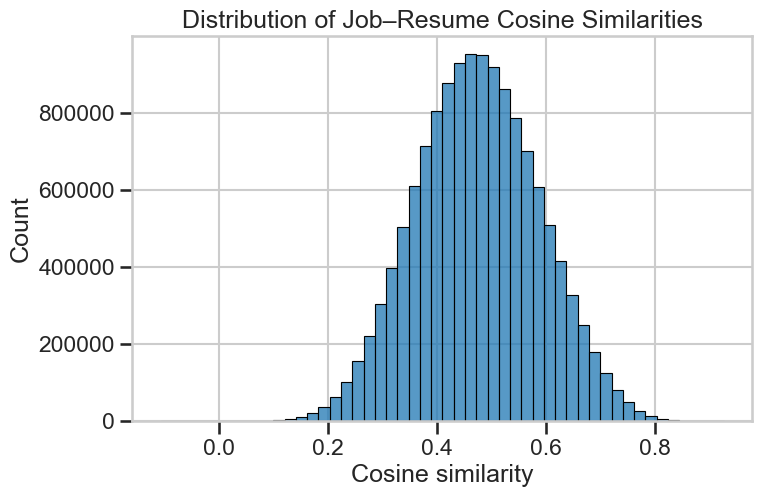

In [4]:
# 1) Distribution of all job–resume cosine similarities
flat = cosine_scores.ravel()
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(flat, bins=50, ax=ax, kde=False, color='#1f77b4')
ax.set_title('Distribution of Job–Resume Cosine Similarities')
ax.set_xlabel('Cosine similarity')
ax.set_ylabel('Count')
plt.show()

Computed top-5 averages per job in 0.586s


Computed top-5 averages per job in 0.586s


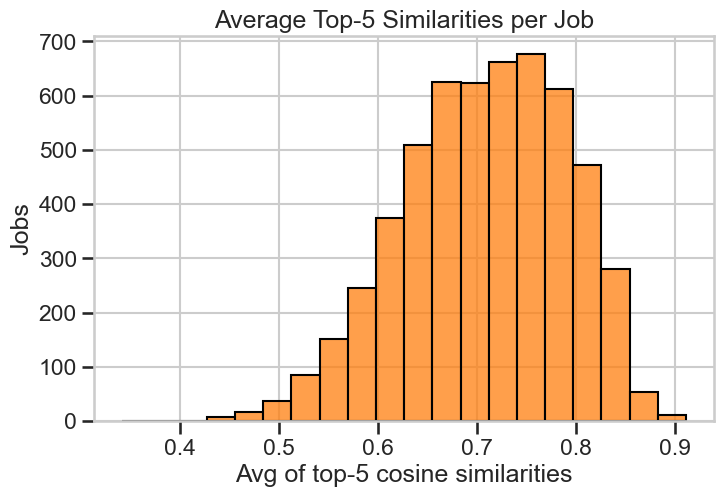

In [5]:
# 2) For each job, compute the average of its top-K similarities
TOP_K = 5

def topk_mean(row: np.ndarray, k: int) -> float:
    k = min(k, row.size)
    # argpartition for O(n) top-k without full sort
    idx = np.argpartition(row, -k)[-k:]
    return float(row[idx].mean())

t0 = time.time()
topk_avgs = np.apply_along_axis(lambda r: topk_mean(r, TOP_K), 1, cosine_scores)
t1 = time.time()
print(f'Computed top-{TOP_K} averages per job in {t1 - t0:.3f}s')

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(topk_avgs, bins=20, ax=ax, color='#ff7f0e')
ax.set_title(f'Average Top-{TOP_K} Similarities per Job')
ax.set_xlabel(f'Avg of top-{TOP_K} cosine similarities')
ax.set_ylabel('Jobs')
plt.show()

In [6]:
# 3) Basic summary statistics
print('Global Stats:')
print(f'  Mean cosine similarity: {np.mean(flat):.4f}')
print(f'  Std deviation:          {np.std(flat):.4f}')
print(f'  Min / Max:               {np.min(flat):.4f} / {np.max(flat):.4f}')
print(f'  Mean top-{TOP_K}:          {np.mean(topk_avgs):.4f}')

Global Stats:
  Mean cosine similarity: 0.4747
  Std deviation:          0.1132
  Min / Max:               -0.1066 / 0.9277
  Mean top-5:          0.7087


In [7]:
# 4) Separation heuristic: proportion of pairs above certain thresholds
thresholds = [0.5, 0.6, 0.7]
props = {thr: float((flat > thr).mean()) for thr in thresholds}
for thr, p in props.items():
    print(f'Proportion of matches > {thr:.2f}: {p:.2%}')

Proportion of matches > 0.50: 41.09%
Proportion of matches > 0.60: 14.03%
Proportion of matches > 0.70: 2.27%


In [8]:
# 5) Timing check on a small batch
n_probe = min(5, job_embeddings.shape[0])
t0 = time.time()
_ = cosine_similarity(job_embeddings[:n_probe], resume_embeddings)
t1 = time.time()
print(f'Cosine similarity wall time for {n_probe} jobs vs all resumes: {t1 - t0:.3f}s')

Cosine similarity wall time for 5 jobs vs all resumes: 0.012s


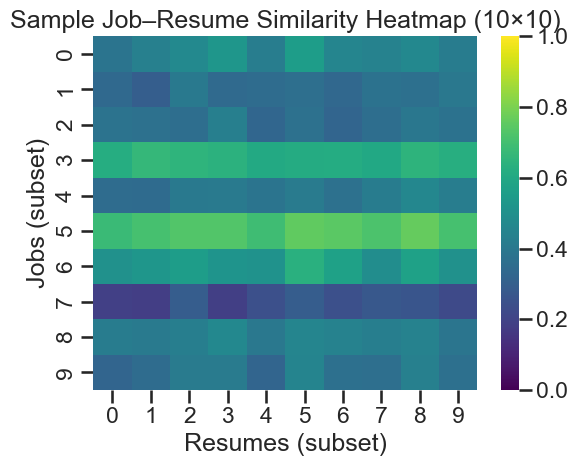

In [9]:
# (Optional) Visual sample: small heatmap for a 10x10 block
j = min(10, cosine_scores.shape[0])
r = min(10, cosine_scores.shape[1])
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cosine_scores[:j, :r], vmin=0.0, vmax=1.0, cmap='viridis', ax=ax)
ax.set_title('Sample Job–Resume Similarity Heatmap (10×10)')
ax.set_xlabel('Resumes (subset)')
ax.set_ylabel('Jobs (subset)')
plt.tight_layout()
plt.show()

## Compare cosine-only vs reranked results
We rerank the top-N cosine candidates for each job using a cross-encoder (ms-marco-MiniLM-L-6-v2) over raw texts, then compare:
- Overlap@k and Jaccard between top-k sets
- Correlation between cosine and cross-encoder scores on the candidate set
- Average top-k scores (cosine before, cross-encoder after)

Notes: Downloads model on first run, can take time; uses GPU if available.

In [10]:
# Rerank top-N cosine candidates and compute comparison metrics
from sentence_transformers import CrossEncoder
import torch
from scipy.stats import spearmanr, pearsonr

device = "cuda" if torch.cuda.is_available() else "cpu"
cross = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", device=device)

def _get_job_text(row):
    for c in ["job_text_clean", "job_text", "Description", "JobDescription", "JD", "Text"]:
        if c in row and isinstance(row[c], str) and row[c].strip():
            return row[c]
    return ""

def _get_resume_text(row):
    for c in ["Resume_clean", "Resume", "Text", "Summary"]:
        if c in row and isinstance(row[c], str) and row[c].strip():
            return row[c]
    return ""

def _topk_indices(scores: np.ndarray, k: int) -> np.ndarray:
    k = min(k, scores.shape[0])
    idx = np.argpartition(scores, -k)[-k:]
    return idx[np.argsort(scores[idx])[::-1]]

def rerank_for_job_idx(job_idx: int, preselect: int = 50, k: int = 5, batch_size: int = 32):
    """Return dict with reranked indices/scores and candidate-level arrays for analysis."""
    scores = cosine_scores[job_idx]
    m = min(preselect, scores.size)
    cand = np.argpartition(scores, -m)[-m:]
    cand = cand[np.argsort(scores[cand])[::-1]]  # cosine-desc

    job_text = _get_job_text(job_df.iloc[job_idx])
    if not job_text:
        return None

    cand_texts = [(_get_resume_text(resume_df.iloc[i]), i) for i in cand]
    keep = [(t, i) for (t, i) in cand_texts if t]
    if not keep:
        return None
    pairs = [(job_text, t) for (t, _) in keep]
    cand_idxs = np.array([i for (_, i) in keep], dtype=int)

    ce_scores = cross.predict(pairs, batch_size=batch_size)
    order = np.argsort(-ce_scores)
    k_final = min(k, len(cand_idxs))
    final_idxs = cand_idxs[order[:k_final]]
    final_scores = ce_scores[order[:k_final]]
    cos_scores_on_cand = scores[cand_idxs]

    # top-k by cosine (before rerank)
    topk_cosine = cand[:k_final]
    return {
        "final_idxs": final_idxs,
        "final_ce": final_scores,
        "cand_idxs": cand_idxs,
        "ce_scores": ce_scores,
        "cos_cand": cos_scores_on_cand,
        "topk_cosine": topk_cosine,
    }

c:\Users\adity\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compared 30 jobs (sample of 30).

Macro means:


Compared 30 jobs (sample of 30).

Macro means:


overlap_at_k              0.933333
overlap_ratio             0.186667
jaccard_at_k              0.112434
spearman                  0.203656
pearson                   0.219937
avg_cosine_topk_before    0.695927
avg_ce_topk_after        -0.844409
dtype: float64

Compared 30 jobs (sample of 30).

Macro means:


overlap_at_k              0.933333
overlap_ratio             0.186667
jaccard_at_k              0.112434
spearman                  0.203656
pearson                   0.219937
avg_cosine_topk_before    0.695927
avg_ce_topk_after        -0.844409
dtype: float64

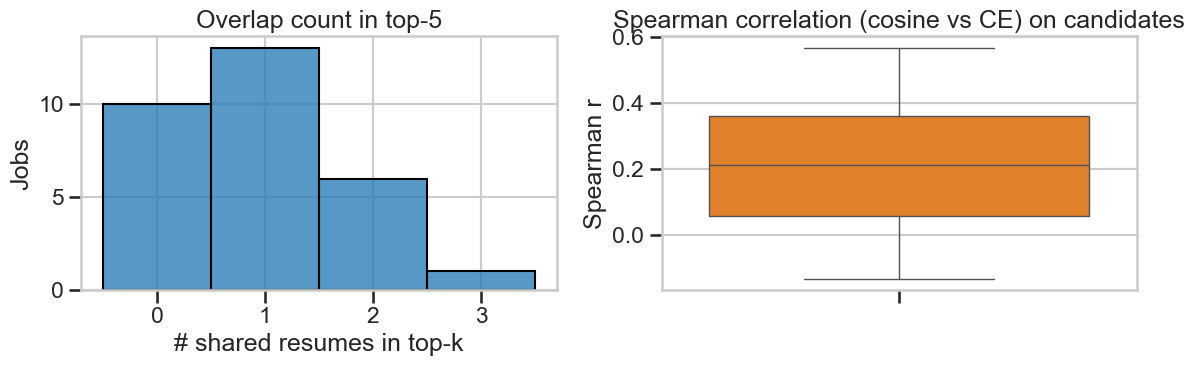

In [11]:
# Run comparison over a random sample of jobs
PRESELECT = 50
K = 5
SAMPLE_JOBS = min(30, cosine_scores.shape[0])
rng = np.random.default_rng(42)
job_indices = rng.choice(cosine_scores.shape[0], size=SAMPLE_JOBS, replace=False)

rows = []
example_scatter = None
for j in job_indices:
    res = rerank_for_job_idx(int(j), preselect=PRESELECT, k=K, batch_size=32)
    if res is None:
        continue
    # sets for overlap
    topk_cos = set(res["topk_cosine"])
    topk_ce  = set(res["final_idxs"])
    inter = len(topk_cos & topk_ce)
    union = len(topk_cos | topk_ce) if (topk_cos or topk_ce) else 1
    jacc = inter / union
    overlap_ratio = inter / float(K)
    # correlations on candidate set
    try:
        sp = spearmanr(res["cos_cand"], res["ce_scores"]).correlation
    except Exception:
        sp = np.nan
    try:
        pr = pearsonr(res["cos_cand"], res["ce_scores"]).statistic if hasattr(pearsonr(res["cos_cand"], res["ce_scores"]), 'statistic') else pearsonr(res["cos_cand"], res["ce_scores"])[0]
    except Exception:
        pr = np.nan
    avg_cos_topk = float(np.mean(cosine_scores[int(j), list(topk_cos)])) if topk_cos else np.nan
    avg_ce_topk  = float(np.mean(res["final_ce"])) if len(res["final_ce"])>0 else np.nan
    rows.append({
        "job_idx": int(j),
        "overlap_at_k": inter,
        "overlap_ratio": overlap_ratio,
        "jaccard_at_k": jacc,
        "spearman": sp,
        "pearson": pr,
        "avg_cosine_topk_before": avg_cos_topk,
        "avg_ce_topk_after": avg_ce_topk,
    })

cmp_df = pd.DataFrame(rows)
print(f"Compared {len(cmp_df)} jobs (sample of {SAMPLE_JOBS}).")
if not cmp_df.empty:
    print("\nMacro means:")
    display(cmp_df[["overlap_at_k","overlap_ratio","jaccard_at_k","spearman","pearson","avg_cosine_topk_before","avg_ce_topk_after"]].mean(numeric_only=True))

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(cmp_df["overlap_at_k"], bins=range(0, K+2), discrete=True, ax=axes[0], color="#1f77b4")
    axes[0].set_title(f"Overlap count in top-{K}")
    axes[0].set_xlabel("# shared resumes in top-k")
    axes[0].set_ylabel("Jobs")
    sns.boxplot(y=cmp_df["spearman"], ax=axes[1], color="#ff7f0e")
    axes[1].set_title("Spearman correlation (cosine vs CE) on candidates")
    axes[1].set_ylabel("Spearman r")
    plt.tight_layout()
    plt.show()

In [12]:
# Optional: if labels exist, compute Precision@K for cosine vs reranked
import os
labels_path = os.path.join(DATA_DIR, "labels_pairs.csv")
if os.path.exists(labels_path):
    print(f"Found labels at {labels_path}. Evaluating P@{K} on a small set...")
    labels = pd.read_csv(labels_path)  # expects: job_id, resume_id, label (1/0)

    job_id_col = "ID" if "ID" in job_df.columns else None
    res_id_col = "ID" if "ID" in resume_df.columns else None
    if not job_id_col or not res_id_col:
        print("Missing ID columns in jobs/resumes; skipping labeled eval.")
    else:
        job_to_idx = {jid: i for i, jid in enumerate(job_df[job_id_col].tolist())}
        res_to_idx = {rid: i for i, rid in enumerate(resume_df[res_id_col].tolist())}
        # Build relevance sets
        rel = {}
        for _, r in labels.iterrows():
            j = job_to_idx.get(r["job_id"])
            s = res_to_idx.get(r["resume_id"])
            if j is None or s is None:
                continue
            if int(r.get("label", 1)) == 1:
                rel.setdefault(int(j), set()).add(int(s))

        eval_jobs = list(rel.keys())
        if not eval_jobs:
            print("No positive labels found after ID mapping; skipping.")
        else:
            # Limit to avoid heavy CE calls
            max_eval = min(50, len(eval_jobs))
            rng = np.random.default_rng(123)
            eval_subset = rng.choice(eval_jobs, size=max_eval, replace=False)
            def precision_at_k(relset, ranked, k):
                if k == 0: return 0.0
                return sum(1 for i in ranked[:k] if i in relset) / float(k)
            p_rows = []
            for j in eval_subset:
                # cosine top-k
                cos_scores = cosine_scores[j]
                idx = np.argpartition(cos_scores, -K)[-K:]
                idx = idx[np.argsort(cos_scores[idx])[::-1]]
                p_cos = precision_at_k(rel.get(j, set()), idx, K)
                # reranked top-k
                rr = rerank_for_job_idx(j, preselect=PRESELECT, k=K, batch_size=32)
                if rr is None:
                    continue
                p_ce = precision_at_k(rel.get(j, set()), rr["final_idxs"], K)
                p_rows.append({"job_idx": j, "P@K_cosine": p_cos, "P@K_reranked": p_ce})
            p_df = pd.DataFrame(p_rows)
            if not p_df.empty:
                print("Macro means (labels):")
                display(p_df[["P@K_cosine","P@K_reranked"]].mean(numeric_only=True))
            else:
                print("No evaluated jobs produced results.")
else:
    print("No labels_pairs.csv found; skipping labeled evaluation.")

No labels_pairs.csv found; skipping labeled evaluation.


## Cluster-based sanity check
We'll cluster resumes and jobs together in the same embedding space and then measure whether the top-k matches for each job land in the same cluster as the job.

Metrics:
- match_cluster_rate@k: fraction of top-k candidates that share job's cluster (averaged over jobs)
- strict_hit@k: % jobs with at least one candidate in same cluster
- silhouette (optional): global clustering quality indicator

We use MiniBatchKMeans for speed and normalize embeddings first for cosine-like behavior.

In [ ]:
# Perform clustering and compute cluster-based match metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Normalization helper (idempotent)
def _l2_norm_rows(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True)
    n = np.maximum(n, eps)
    return x / n

jobs_norm = _l2_norm_rows(job_embeddings.astype(np.float32))
resumes_norm = _l2_norm_rows(resume_embeddings.astype(np.float32))

# Combine for clustering
combined = np.vstack([jobs_norm, resumes_norm])
num_jobs = jobs_norm.shape[0]
num_resumes = resumes_norm.shape[0]

# Heuristic for number of clusters
k_clusters = max(16, min(128, int(np.sqrt(num_jobs + num_resumes))))
print(f'Clustering {combined.shape[0]} vectors into {k_clusters} clusters...')
kmeans = MiniBatchKMeans(n_clusters=k_clusters, batch_size=2048, random_state=42)
cluster_labels = kmeans.fit_predict(combined)

job_cluster_labels = cluster_labels[:num_jobs]
resume_cluster_labels = cluster_labels[num_jobs:]

# Cluster size summary
cluster_sizes_jobs = pd.Series(job_cluster_labels).value_counts().sort_index()
cluster_sizes_resumes = pd.Series(resume_cluster_labels).value_counts().sort_index()
print('Job cluster size (head):')
display(cluster_sizes_jobs.head())
print('Resume cluster size (head):')
display(cluster_sizes_resumes.head())

# Optional silhouette (can be expensive if dataset large)
try:
    sil = silhouette_score(combined, cluster_labels)
    print(f'Silhouette score (combined): {sil:.4f}')
except Exception as e:
    print('Silhouette score failed:', e)

K_FINAL = 5  # use same k as earlier comparisons

def cluster_match_metrics(topk_indices_func, label_array_jobs, label_array_resumes, k: int = K_FINAL):
    match_rates = []
    strict_hits = 0
    for j in range(num_jobs):
        job_cl = label_array_jobs[j]
        # top-k resume indices for this job using existing cosine_scores
        scores = cosine_scores[j]
        idx = np.argpartition(scores, -k)[-k:]
        idx = idx[np.argsort(scores[idx])[::-1]]  # sorted
        resume_cls = label_array_resumes[idx]
        rate = float(np.mean(resume_cls == job_cl))
        match_rates.append(rate)
        if np.any(resume_cls == job_cl):
            strict_hits += 1
    return {
        'match_cluster_rate_at_k': np.mean(match_rates),
        'strict_hit_at_k': strict_hits / num_jobs,
    }

# Cosine-only cluster match
cosine_cluster_stats = cluster_match_metrics(_topk_indices, job_cluster_labels, resume_cluster_labels, k=K_FINAL)
print('Cosine-only cluster match stats:')
print(cosine_cluster_stats)

# Reranked cluster match (using previously defined rerank_for_job_idx)
rerank_rates = []
rerank_hits = 0
evaluated_jobs = 0
for j in range(num_jobs):
    rr = rerank_for_job_idx(j, preselect=50, k=K_FINAL, batch_size=32)
    if rr is None:
        continue
    evaluated_jobs += 1
    job_cl = job_cluster_labels[j]
    resume_cls = resume_cluster_labels[rr['final_idxs']]
    rate = float(np.mean(resume_cls == job_cl))
    rerank_rates.append(rate)
    if np.any(resume_cls == job_cl):
        rerank_hits += 1

if evaluated_jobs > 0:
    rerank_cluster_stats = {
        'match_cluster_rate_at_k': np.mean(rerank_rates),
        'strict_hit_at_k': rerank_hits / evaluated_jobs,
        'jobs_evaluated': evaluated_jobs,
    }
    print('Reranked cluster match stats:')
    print(rerank_cluster_stats)
else:
    print('No jobs evaluated for reranked cluster stats (possibly missing text columns).')

Clustering 7932 vectors into 89 clusters...
Job cluster size (head):
Job cluster size (head):


Clustering 7932 vectors into 89 clusters...
Job cluster size (head):
Job cluster size (head):


0     1
1    17
2    96
3    41
5    51
Name: count, dtype: int64

Resume cluster size (head):


0     36
1    128
3      6
4     15
6     85
Name: count, dtype: int64

Clustering 7932 vectors into 89 clusters...
Job cluster size (head):
Job cluster size (head):


0     1
1    17
2    96
3    41
5    51
Name: count, dtype: int64

Resume cluster size (head):


0     36
1    128
3      6
4     15
6     85
Name: count, dtype: int64

Silhouette score (combined): 0.0585
Cosine-only cluster match stats:
{'match_cluster_rate_at_k': np.float64(0.11358296622613805), 'strict_hit_at_k': 0.2094346549192364}
Cosine-only cluster match stats:
{'match_cluster_rate_at_k': np.float64(0.11358296622613805), 'strict_hit_at_k': 0.2094346549192364}
